In [25]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

seed=42

In [26]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


In [27]:
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [28]:
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [29]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Positive', 'Neutral']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [30]:
df = pd.read_csv('/kaggle/input/amerix-sa-nlp-deep-cleaned-data/sentiment_adv_preprocessed_data.csv', index_col=0)

In [31]:
df.head()

,tweet_created_at,text_clean,Sentiment
0,2022-05-20 16:01:49+00:00,actor amp cookbook author recently joined the ...,1
1,2022-08-23 15:26:31+00:00,sprinkled a little kindness to brighten someon...,1
2,2021-10-15 17:23:25+00:00,the body is not stupid it has an efficient hom...,1
3,2022-11-19 16:26:01+00:00,food for the thought masculinitysaturday,2
4,2022-12-12 08:59:22+00:00,why though,2


In [32]:
ros = RandomOverSampler()

train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));

ros_df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [33]:
ros_df['Sentiment'].value_counts()

1    129038
2    129038
0    129038
Name: Sentiment, dtype: int64

In [34]:
X = ros_df['text_clean'].values
y = ros_df['Sentiment'].values

In [35]:
x_, x_test, y_, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [36]:
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size=0.2, stratify=y_, random_state=42)

In [37]:
y_train_c = y_train.copy()
y_valid_c = y_val.copy()
y_test_c = y_test.copy()

In [38]:
encoder = preprocessing.OneHotEncoder()

y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = encoder.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [39]:
print(f"Training Data: {x_train.shape[0]}\nValidation Data: {x_val.shape[0]}\nTesting Data: {x_test.shape[0]}" )

Training Data: 216783
Validation Data: 54196
Testing Data: 116135


In [41]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [42]:
MAX_LEN = 128

In [43]:
def tokenize(data, max_len=MAX_LEN) :
    
    input_ids = []
    attention_masks = []
    
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [44]:
train_input_ids, train_attention_masks = tokenize(x_train, MAX_LEN)

val_input_ids, val_attention_masks = tokenize(x_val, MAX_LEN)

test_input_ids, test_attention_masks = tokenize(x_test, MAX_LEN)

In [45]:
bert_classifier = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [46]:
def create_model(bert_model, max_len=MAX_LEN):
    
    #parameters
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_classifier([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [47]:
brt_model = create_model(bert_classifier, MAX_LEN)
brt_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3)            2307        tf_bert_model_1[0][1]      

In [48]:
bert_train_tune = brt_model.fit([train_input_ids,train_attention_masks], 
                         y_train, 
                         validation_data = ([val_input_ids,val_attention_masks], y_val), 
                         epochs=4, batch_size=32)

Epoch 1/4
6775/6775 [==============================] - 3492s 513ms/step - loss: 0.2768 - categorical_accuracy: 0.9039 - val_loss: 0.1633 - val_categorical_accuracy: 0.9472
Epoch 2/4
6775/6775 [==============================] - 3473s 513ms/step - loss: 0.1381 - categorical_accuracy: 0.9563 - val_loss: 0.1285 - val_categorical_accuracy: 0.9586
Epoch 3/4
6775/6775 [==============================] - 3473s 513ms/step - loss: 0.0951 - categorical_accuracy: 0.9690 - val_loss: 0.1140 - val_categorical_accuracy: 0.9653
Epoch 4/4
6775/6775 [==============================] - 3475s 513ms/step - loss: 0.0678 - categorical_accuracy: 0.9778 - val_loss: 0.1219 - val_categorical_accuracy: 0.9669


In [49]:
bert_prediction = brt_model.predict([test_input_ids,test_attention_masks])

In [52]:
bert_y_predictions =  np.zeros_like(bert_prediction)
bert_y_predictions[np.arange(len(bert_y_predictions)), bert_prediction.argmax(1)] = 1

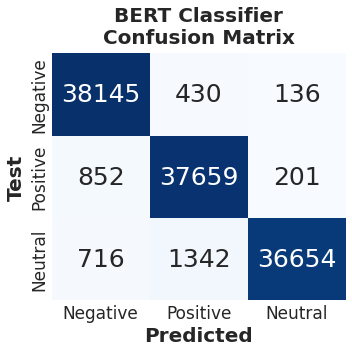

In [53]:
conf_matrix(y_test.argmax(1), bert_y_predictions.argmax(1),'BERT Classifier\nConfusion Matrix')

In [54]:

print('\tBERT Classification Report\n\n',classification_report(y_test,bert_y_predictions, 
                                                                    target_names=['Negative', 'Positive', 'Neutral']))

	BERT Classification Report

               precision    recall  f1-score   support

    Negative       0.96      0.99      0.97     38711
    Positive       0.96      0.97      0.96     38712
     Neutral       0.99      0.95      0.97     38712

   micro avg       0.97      0.97      0.97    116135
   macro avg       0.97      0.97      0.97    116135
weighted avg       0.97      0.97      0.97    116135
 samples avg       0.97      0.97      0.97    116135

